In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt

## Multi-Input 모델을 이용한 Kor-Bab QA 데이터 셋 분석

### Step 1. Input tensor 와 Target tensor 준비(훈련데이터)

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1xjztJzSPihlBIkgez1WutAdIoAP-D47S" -O "train.txt"
!wget "https://drive.google.com/uc?export=download&id=18WWa1gmPjyrI9N9jXDEPLnpA456sTdxu" -O "test.txt"

--2021-07-14 02:30:42--  https://drive.google.com/uc?export=download&id=1xjztJzSPihlBIkgez1WutAdIoAP-D47S
Resolving drive.google.com (drive.google.com)... 108.177.126.102, 108.177.126.138, 108.177.126.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7gagmc4lsee50isvlfcj7o7qpnr8kal2/1626229800000/13472183013488020071/*/1xjztJzSPihlBIkgez1WutAdIoAP-D47S?e=download [following]
--2021-07-14 02:30:42--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7gagmc4lsee50isvlfcj7o7qpnr8kal2/1626229800000/13472183013488020071/*/1xjztJzSPihlBIkgez1WutAdIoAP-D47S?e=download
Resolving doc-14-94-docs.googleusercontent.com (doc-14-94-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Connecting to doc-14-94-docs.googleusercontent.com (d

(1) Kor-Babi 데이터 셋 load

In [ ]:
# 다운로드 받은 데이터를 읽어 들여 Input tensor 와 Target tensor 준비
with np.load('/content/Kor-Babi-QA.npz', allow_pickle=True) as a:
  train_story = a['train_story']
  train_question = a['train_question']
  train_labels = a['train_labels']
  
  test_story = a['test_story']
  test_question = a['test_question']
  test_labels = a['test_labels']

In [ ]:
with open('kor-babi-word2idx.json') as json_file:
    word2idx = json.load(json_file)

In [ ]:
with open('kor-babi-idx2word.json') as json_file:
    idx2word = json.load(json_file)

In [ ]:
train_story.shape, train_question.shape, train_labels.shape

((10000,), (10000, 5), (10000,))

In [ ]:
train_story[0]

[9, 1, 14, 3, 17, 2, 7, 1, 16, 3, 10, 4, 2]

In [ ]:
train_question[0]

array([9, 1, 21, 22, 23], dtype=object)

In [ ]:
train_labels[0]

14

(2) 데이터셋 가공을 위한 정보 분석

In [ ]:
story_max_len = max([len(story) for story in train_story])
question_max_len = max([len(question) for question in train_question])

In [ ]:
story_max_len, question_max_len

(70, 5)

In [ ]:
vocab_size = len(idx2word) +1

In [ ]:
vocab_size

24

In [ ]:
len(idx2word)

23

(3) 데이터셋의 전처리 작업 수행
* story, question : 동일한 길이를 갖도록 변경
* label : one-hot encoding 수행


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
train_story = pad_sequences(train_story, maxlen=story_max_len)
train_question = pad_sequences(train_question, maxlen=question_max_len)
train_labels = to_categorical(train_labels, num_classes=vocab_size)

In [ ]:
test_story = pad_sequences(test_story, maxlen=story_max_len)
test_question = pad_sequences(test_question, maxlen=question_max_len)
test_labels = to_categorical(test_labels, num_classes=vocab_size)

In [ ]:
train_story.shape, train_question.shape, train_labels.shape

((10000, 70), (10000, 5), (10000, 24))

In [ ]:
test_story.shape, test_question.shape, test_labels.shape

((1000, 70), (1000, 5), (1000, 24))

### Step 2. Multi Input 모델 정의

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
embedding = layers.Embedding(input_dim=vocab_size, output_dim=128)

(1) story 데이터를 분석하기 위한 path 설계

In [ ]:
story_input = keras.Input(shape=(story_max_len, ), name='story')

story_feature = embedding(story_input)
# LSTM(64)
story_feature = layers.LSTM(64)(story_feature)

(2) question 데이터를 분석하기 위한 path 설계

In [ ]:
question_input = keras.Input(shape=(question_max_len, ), name='question')

question_feature = embedding(question_input)
# LSTM(32)
question_feature = layers.LSTM(32)(question_feature)

(3) 2개의 input 데이터(story, question)를 분석하여 정답 token을 classification 하기 위한 path 설계

In [ ]:
concatenated = layers.Concatenate()([story_feature, question_feature])
concatenated = layers.concatenate([story_feature, question_feature])

x = layers.Dense(64, 'relu')(concatenated)
x = layers.Dropout(0.2)(x)
output = layers.Dense(vocab_size, 'softmax')(x)

(3) 설계한 path 를 이용하여 모델 객체 생성

In [ ]:
model = keras.Model(
    inputs=[story_input, question_input],
    outputs=output
)

In [ ]:
from tensorflow.keras.utils import plot_model

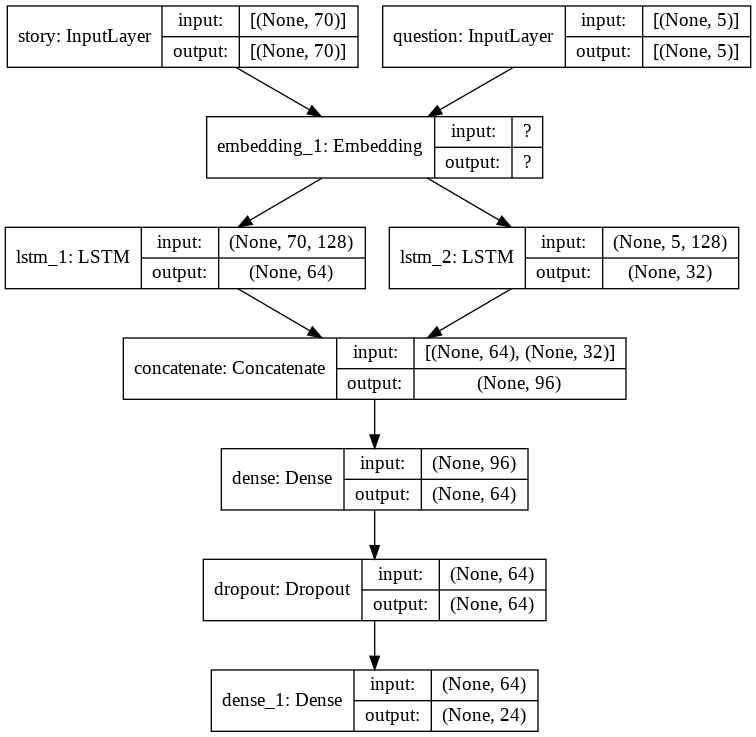

In [ ]:
plot_model(model, show_shapes=True)

### Step 3. 학습 정보 설정

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Step 4. 학습 데이터를 연결하여 학습 시작

In [ ]:
history = model.fit(x={'story':train_story,
                       'question':train_question},
                    y=train_labels,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2)

Epoch 1/60
250/250 [==============================] - 8s 10ms/step - loss: 1.7396 - accuracy: 0.2810 - val_loss: 1.3679 - val_accuracy: 0.4960
Epoch 2/60
250/250 [==============================] - 2s 8ms/step - loss: 1.2349 - accuracy: 0.5104 - val_loss: 1.1502 - val_accuracy: 0.5345
Epoch 3/60
250/250 [==============================] - 2s 8ms/step - loss: 1.1308 - accuracy: 0.5291 - val_loss: 1.1408 - val_accuracy: 0.5020
Epoch 4/60
250/250 [==============================] - 2s 8ms/step - loss: 1.0870 - accuracy: 0.5163 - val_loss: 1.0738 - val_accuracy: 0.5280
Epoch 5/60
250/250 [==============================] - 2s 8ms/step - loss: 1.0617 - accuracy: 0.5216 - val_loss: 1.0793 - val_accuracy: 0.5290
Epoch 6/60
250/250 [==============================] - 2s 8ms/step - loss: 1.0475 - accuracy: 0.5350 - val_loss: 1.0619 - val_accuracy: 0.5175
Epoch 7/60
250/250 [==============================] - 2s 8ms/step - loss: 1.0373 - accuracy: 0.5301 - val_loss: 1.0585 - val_accuracy: 0.5140
Epoch

### Step 5. 테스트 데이터를 이용한 성능 검증

In [ ]:
test_loss, test_accuracy = model.evaluate(x={'story':test_story,
                                             'question':test_question},
                                          y=test_labels,)

32/32 [==============================] - 0s 4ms/step - loss: 1.1556 - accuracy: 0.7630


### Appendix 1. 학습 이력 시각화

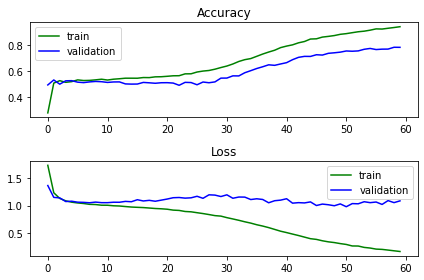

In [ ]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="g", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Appendix 2. 모델의 예측 결과 확인

In [ ]:
ytest = np.argmax(test_labels, axis=1)

predict = model.predict(x={'story' : test_story,
                          'question' : test_question})
predict = np.argmax(predict, axis=1)

In [ ]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[str(x)] for x in test_question[i].tolist()])
    label = idx2word[str(ytest[i])]
    prediction = idx2word[str(predict[i])]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도      복도
필웅이 는 어디 야 ?        : 화장실     화장실
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 사무실     사무실
수종이 는 어디 야 ?        : 사무실     복도
필웅이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 정원      부엌
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 침실      부엌
필웅이 는 어디 야 ?        : 침실      침실
은경이 는 어디 야 ?        : 부엌      부엌
은경이 는 어디 야 ?        : 정원      정원
은경이 는 어디 야 ?        : 부엌      부엌
수종이 는 어디 야 ?        : 사무실     복도
은경이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 복도      복도
은경이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 사무실     사무실
경임이 는 어디 야 ?        : 복도      침실
수종이 는 어디 야 ?        : 침실      정원
경임이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
수종이 는 어디 야 ?        : 부엌      부엌
수종

In [ ]:
model.save('my_model.h5')

In [ ]:
from tensorflow.keras import models

In [ ]:
restored_model =  models.load_model('my_model.h5')

In [ ]:
plot_model(restored_model)

In [ ]:
test_loss, test_accuracy = restored_model.evaluate(x={'story':test_story,
                                             'question':test_question},
                                          y=test_labels,)

32/32 [==============================] - 1s 4ms/step - loss: 1.1556 - accuracy: 0.7630


In [ ]:
predict = restored_model.predict(x={'story':test_story,'question':test_question})

In [ ]:
history = restored_model.fit(x={'story':train_story,
                       'question':train_question},
                    y=train_labels,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2)

In [ ]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
del restored_model

In [ ]:
restored_model =  models.load_model('my_model')

In [ ]:
test_loss, test_accuracy = restored_model.evaluate(x={'story':test_story,
                                             'question':test_question},
                                          y=test_labels,)

32/32 [==============================] - 1s 4ms/step - loss: 1.1556 - accuracy: 0.7630
